# Deep Dreams

Work in progress. Attempting to turn a keras model into a conx model.

<table>
    <tr>
        <td><img src="monalisa.jpg" width="256px"></td>
        <td><img src="monalisa-generated.png" width="256px"></td>
    </tr>
</table>

In [1]:
from keras import backend as K
from keras.applications import inception_v3
from keras.preprocessing.image import load_img, img_to_array
import keras

import numpy as np
import scipy
from IPython.display import Image

Using Theano backend.


In [2]:
base_image_path = "monalisa.jpg"
result_prefix = "monolisa-generated"

These are the names of the layers for which we try to maximize activation, as well as their weight in the final loss we try to maximize.

You can tweak these setting to obtain new visual effects.

In [3]:
settings = {
    'features': {
        'mixed2': 0.2,
        'mixed3': 0.5,
        'mixed4': 2.,
        'mixed5': 1.5,
    },
}

In [4]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)

In [5]:
K.set_learning_phase(0)

# Build the InceptionV3 network with our placeholder.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)
dream = model.input
print('Model loaded.')

Model loaded.


In [6]:
from conx import import_keras_model

conx, version 3.4.3


In [7]:
network = import_keras_model(model, "Inception V3")

In [8]:
for clayer in network.layers:
    if clayer.kind() == "hidden":
        clayer.visible = False

In [9]:
img = preprocess_image(base_image_path)

In [10]:
network.dataset._inputs = [img]

In [11]:
network.layers[1].visible = True

In [12]:
network.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=1.0, continuous_update=False, description='Zoom', max=3.0, min=0.5), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('', 'input_1', 'conv2d_1', 'batch_normalization_1', 'activation_1', 'conv2d_2', 'batch_normalization_2', 'activation_2', 'conv2d_3', 'batch_normalization_3', 'activation_3', 'max_pooling2d_1', 'conv2d_4', 'batch_normalization_4', 'activation_4', 'conv2d_5', 'batch_normalization_5', 'activation_5', 'max_pooling2d_2', 'conv2d_9', 'batch_normalization_9', 'activation_9', 'conv2d_7', 'conv2d_10', 'batch_normalization_7', 'batch_normalization_10', 'activation_7', 'activation_10', 'average_pooling2d_1', 'conv2d_6', 'conv2d_8', 'conv2d_11', 'conv2d_12', 'batch_normalization_6', 'batch_normalization_8', 'batch_normalization_11', 'batch_normalization_12', 'activation_6', 'activation_8', 'activation_11', 'activation_12', 'mixed0', 'conv2d_16', 'batch_normalization_16', 'activation_16', 'conv2d_14', 'conv2d_17', 'batch_normalization_14', 'batch_normalization_17', 'activation_14', 'activation_17', 'average_pooling2d_2', 'conv2d_13', 'conv2d_15', 'conv2d_18', 'conv2d_19', 'batch_normalization_13', 'batch_normalization_15', 'batch_normalization_18', 'batch_normalization_19', 'activation_13', 'activation_15', 'activation_18', 'activation_19', 'mixed1', 'conv2d_23', 'batch_normalization_23', 'activation_23', 'conv2d_21', 'conv2d_24', 'batch_normalization_21', 'batch_normalization_24', 'activation_21', 'activation_24', 'average_pooling2d_3', 'conv2d_20', 'conv2d_22', 'conv2d_25', 'conv2d_26', 'batch_normalization_20', 'batch_normalization_22', 'batch_normalization_25', 'batch_normalization_26', 'activation_20', 'activation_22', 'activation_25', 'activation_26', 'mixed2', 'conv2d_28', 'batch_normalization_28', 'activation_28', 'conv2d_29', 'batch_normalization_29', 'activation_29', 'conv2d_27', 'conv2d_30', 'batch_normalization_27', 'batch_normalization_30', 'activation_27', 'activation_30', 'max_pooling2d_3', 'mixed3', 'conv2d_35', 'batch_normalization_35', 'activation_35', 'conv2d_36', 'batch_normalization_36', 'activation_36', 'conv2d_32', 'conv2d_37', 'batch_normalization_32', 'batch_normalization_37', 'activation_32', 'activation_37', 'conv2d_33', 'conv2d_38', 'batch_normalization_33', 'batch_normalization_38', 'activation_33', 'activation_38', 'average_pooling2d_4', 'conv2d_31', 'conv2d_34', 'conv2d_39', 'conv2d_40', 'batch_normalization_31', 'batch_normalization_34', 'batch_normalization_39', 'batch_normalization_40', 'activation_31', 'activation_34', 'activation_39', 'activation_40', 'mixed4', 'conv2d_45', 'batch_normalization_45', 'activation_45', 'conv2d_46', 'batch_normalization_46', 'activation_46', 'conv2d_42', 'conv2d_47', 'batch_normalization_42', 'batch_normalization_47', 'activation_42', 'activation_47', 'conv2d_43', 'conv2d_48', 'batch_normalization_43', 'batch_normalization_48', 'activation_43', 'activation_48', 'average_pooling2d_5', 'conv2d_41', 'conv2d_44', 'conv2d_49', 'conv2d_50', 'batch_normalization_41', 'batch_normalization_44', 'batch_normalization_49', 'batch_normalization_50', 'activation_41', 'activation_44', 'activation_49', 'activation_50', 'mixed5', 'conv2d_55', 'batch_normalization_55', 'activation_55', 'conv2d_56', 'batch_normalization_56', 'activation_56', 'conv2d_52', 'conv2d_57', 'batch_normalization_52', 'batch_normalization_57', 'activation_52', 'activation_57', 'conv2d_53

<IPython.core.display.Javascript object>

Feature 0,Feature 1,Feature 2,Feature 3,Feature 4
Feature 5,Feature 6,Feature 7,Feature 8,Feature 9
Feature 10,Feature 11,Feature 12,Feature 13,Feature 14
Feature 15,Feature 16,Feature 17,Feature 18,Feature 19
Feature 20,Feature 21,Feature 22,Feature 23,Feature 24
Feature 25,Feature 26,Feature 27,Feature 28,Feature 29
Feature 30,Feature 31,Feature 32,Feature 33,Feature 34
Feature 35,Feature 36,Feature 37,Feature 38,Feature 39
Feature 40,Feature 41,Feature 42,Feature 43,Feature 44
Feature 45,Feature 46,Feature 47,Feature 48,Feature 49
Feature 50,Feature 51,Feature 52,Feature 53,Feature 54

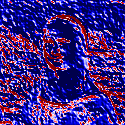
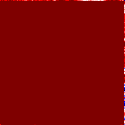
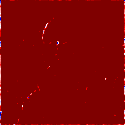
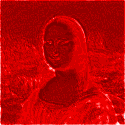
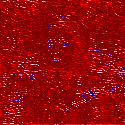
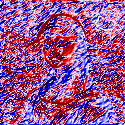
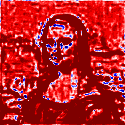
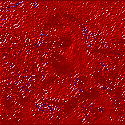
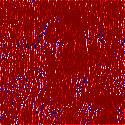
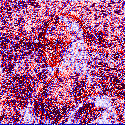
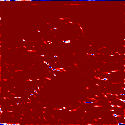
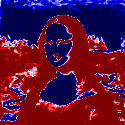
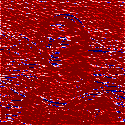
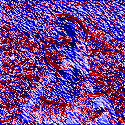
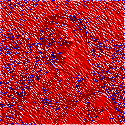
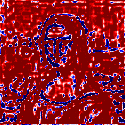
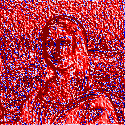
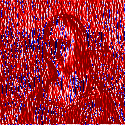
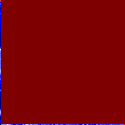
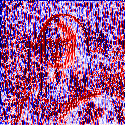
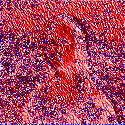
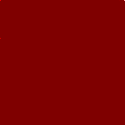
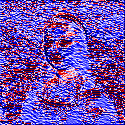
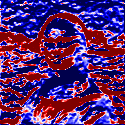
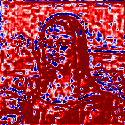
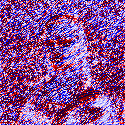
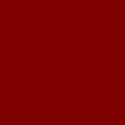
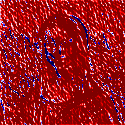
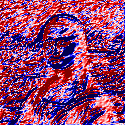
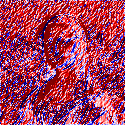
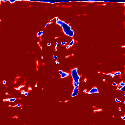
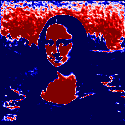
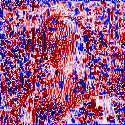
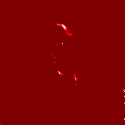
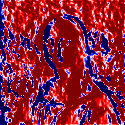
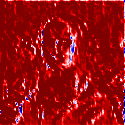
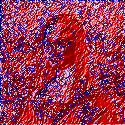
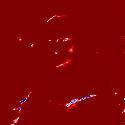
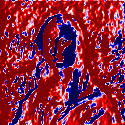
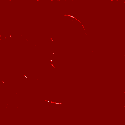
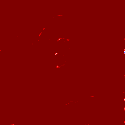
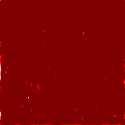
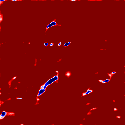
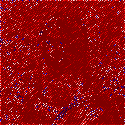
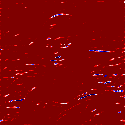
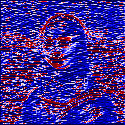
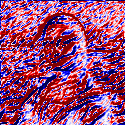
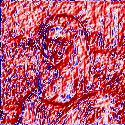
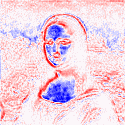
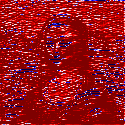
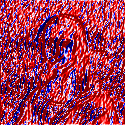
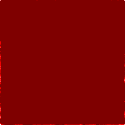
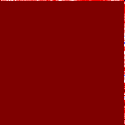
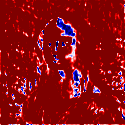
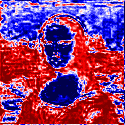
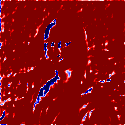
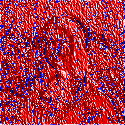
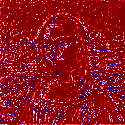
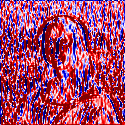
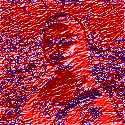
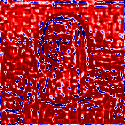
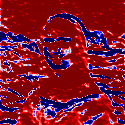
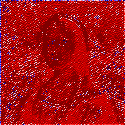
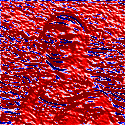

In [13]:
network.propagate_to_features("conv2d_3", img[0])

In [14]:
output = network.propagate(img[0])

In [15]:
from conx import shape
shape(output)

(6, 6, 2048)

In [16]:
network.layers[1].name

'conv2d_1'

In [17]:
output = network.propagate_to("conv2d_1", img[0])

In [18]:
shape(output)

(127, 127, 32)

In [19]:
shape(network.dataset.inputs[0])

(256, 256, 3)

In [20]:
# Define the loss.
loss = K.variable(0.)
for layer_name in settings['features']:
    # Add the L2 norm of the features of a layer to the loss.
    coeff = settings['features'][layer_name]
    x = network[layer_name].keras_layer.output
    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(x), 'float32'))
    if K.image_data_format() == 'channels_first':
        loss += coeff * K.sum(K.square(x[:, :, 2: -2, 2: -2])) / scaling
    else:
        loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling

# Compute the gradients of the dream wrt the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

Process:

- Load the original image.
- Define a number of processing scales (i.e. image shapes),
    from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.

To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.

In [21]:
# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 10.

if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

In [22]:
output1 = model.predict(img)[0]

In [23]:
output2 = network.propagate(img[0])

In [24]:
(output1 == output2).all()

True

In [25]:
from conx import shape, array2image
shape(output2)

(6, 6, 2048)

In [26]:
for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

save_img(img, fname=result_prefix + '.png')

Processing image shape (130, 130)
..Loss value at 0 : 0.3545876443386078
..Loss value at 1 : 0.4975617229938507
..Loss value at 2 : 0.8025295734405518
..Loss value at 3 : 1.158888339996338
..Loss value at 4 : 1.4930806159973145
..Loss value at 5 : 1.6510992050170898
..Loss value at 6 : 1.923414945602417
..Loss value at 7 : 2.1840977668762207
..Loss value at 8 : 2.2317416667938232
..Loss value at 9 : 2.5300564765930176
..Loss value at 10 : 2.722439765930176
..Loss value at 11 : 2.878614902496338
..Loss value at 12 : 3.0598573684692383
..Loss value at 13 : 3.2777538299560547
..Loss value at 14 : 3.3470568656921387
..Loss value at 15 : 3.5682644844055176
..Loss value at 16 : 3.7422337532043457
..Loss value at 17 : 4.028820037841797
..Loss value at 18 : 4.099969863891602
..Loss value at 19 : 4.302164554595947
Processing image shape (182, 182)
..Loss value at 0 : 0.9539443254470825
..Loss value at 1 : 1.6061757802963257
..Loss value at 2 : 2.113076686859131
..Loss value at 3 : 2.34656524658

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


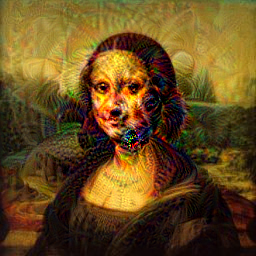

In [27]:
Image(filename="./monalisa-generated.png")